### Import Necessary Packages 

In [165]:
from __future__ import print_function
from IPython.display import Image, display
import cv2
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

### **The Challenge** 👨‍💻

#### Problem Statement: Given an image of particles or rocks 🪨 , **determine their particle size distributions**.

#### For example, given five types of grains 🫘, determine the relative occurrences of each grain type.

1. Rice 15%

1. Green Beans 20%

1. Lentils 40%

1. Kidney Beans 10%

1. Millet 10%

#### Assumptions / Simplification 🤔: 

1. Particles are sparesely populated within the image.

1. The aspect ratio of their height and width does not exceed a certain threshold 

1. We only collect particle samples that we have a confidence in

#### Observation / Conclusion 😎

- We DON'T NEED to detect every particles on the image. 
<br>

- We just **NEED ENOUGH SAMPLES** to estimate the particle size distribution 

### Hyper Parameters

1. NUM_OF_CLASSES - denotes how many different bins/sizes of objects there are

2. FOREGROUN_THRESH - parameter for watershed foreground identification

3. MAX_AR - the maximum allowed aspect ratio of the object (removes too long objects)

In [166]:
NUM_OF_CLASSES = 5
FOREGROUND_THRESH = 0.2
MAX_AR = 2

### Utility Functions 💻

In [167]:
# Plot the image
def imshow(img, ax=None):
    if ax is None:
        ret, encoded = cv2.imencode(".jpg", img)
        display(Image(encoded))
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

In [168]:
def visualizePSD(height, width, particle_sizes, NUM_OF_CLASSES):
    new_size = (height + width) / 2
    real_particle_sizes = [(i * 130 / new_size) for i in particle_sizes]

    # Generate a list of colors based on the number of classes
    cmap = plt.cm.get_cmap('coolwarm')
    colors = [cmap(i) for i in np.linspace(0, 1, NUM_OF_CLASSES)]

    # Calculate the histogram values
    counts, bins, patches = plt.hist(real_particle_sizes, bins=NUM_OF_CLASSES, weights=np.ones(len(real_particle_sizes)) / len(real_particle_sizes))

    # Assign different colors to each bar
    for i in range(len(patches)):
        patches[i].set_facecolor(colors[i % len(colors)])

    plt.xlabel("Particle Size (in mm)")
    plt.ylabel("Particle count")
    plt.title("Particle Size Distribution")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.grid(True)

    histogram_list = []
    histogram_list.append(plt.gcf())
    return histogram_list

In [169]:
def remove_outliers(numbers):
    # Calculate the interquartile range (IQR)
    q1 = np.percentile(numbers, 5)
    q3 = np.percentile(numbers, 95)
    iqr_value = q3 - q1

    # Define the lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value

    # Remove outliers from the list
    filtered_numbers = [x for x in numbers if lower_bound <= x <= upper_bound]

    return filtered_numbers

In [170]:
def watershed_segmentation(img_path):
    image = cv2.imread(img_path)
    image = cv2.medianBlur(image, 5)
    shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
    
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    __, th = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel,iterations=1)

    
    sure_bg = cv2.dilate(th, kernel, iterations=3)
    dist = cv2.distanceTransform(th, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist, FOREGROUND_THRESH * dist.max(), 255, cv2.THRESH_BINARY)
    sure_fg = cv2.erode(sure_fg, kernel, iterations=1)
    sure_fg = sure_fg.astype(np.uint8)  
    unknown = cv2.subtract(sure_bg, sure_fg)

    ret, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(image, markers)

    labels = np.unique(markers)
    mask = np.zeros_like(image)
    particles = []
    particle_sizes = []
    for label in labels[2:]:
        target = np.where(markers == label, 255, 0).astype(np.uint8)
        
        # Perform contour extraction
        contours, hierarchy = cv2.findContours(
            target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
            
        rect = cv2.minAreaRect(contours[0])
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        # Calculate the width and height of the rectangle
        width = np.linalg.norm(box[0] - box[1])
        height = np.linalg.norm(box[1] - box[2])
        smaller_dim = min(width, height)
        bigger_dim = max(width, height)

        aspect_ratio = bigger_dim/smaller_dim

        if smaller_dim == 0:
            continue

        if aspect_ratio > MAX_AR:
            continue

        particle_sizes.append(smaller_dim)
        cv2.drawContours(mask, [box], 0, (0, 255, 0), 2)

        particles.append(contours[0])

    particle_sizes = remove_outliers(particle_sizes)
    height, width = image.shape[0], image.shape[1]

    return image, th, mask, visualizePSD(height, width, particle_sizes, NUM_OF_CLASSES)

### Pre-processing

1. Applies median filter, which removes salt-pepper noises (i.e removes small dots)

 2. Then, applies mean shift filtering, which flattens any small variations in textures and color locally (i.e make it cartoonish)

In [171]:
image = cv2.imread('sample_val.png')
image = cv2.medianBlur(image, 5)
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
plt.figure(figsize=(14, 6))
plt.subplot(121),plt.imshow(image,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])🤔
plt.subplot(122),plt.imshow(shifted,cmap = 'gray')
plt.title('Pre-processed Image'), plt.xticks([]), plt.yticks([])
plt.show()

SyntaxError: invalid character '🤔' (U+1F914) (2170625035.py, line 6)

### More Preprocessing :D

1. We now transform our RGB colored image into gray-scale image (i.e make it look early 20th century)

2. Then, we apply thresholding operation, which turns every foreground objects as white, and background as black

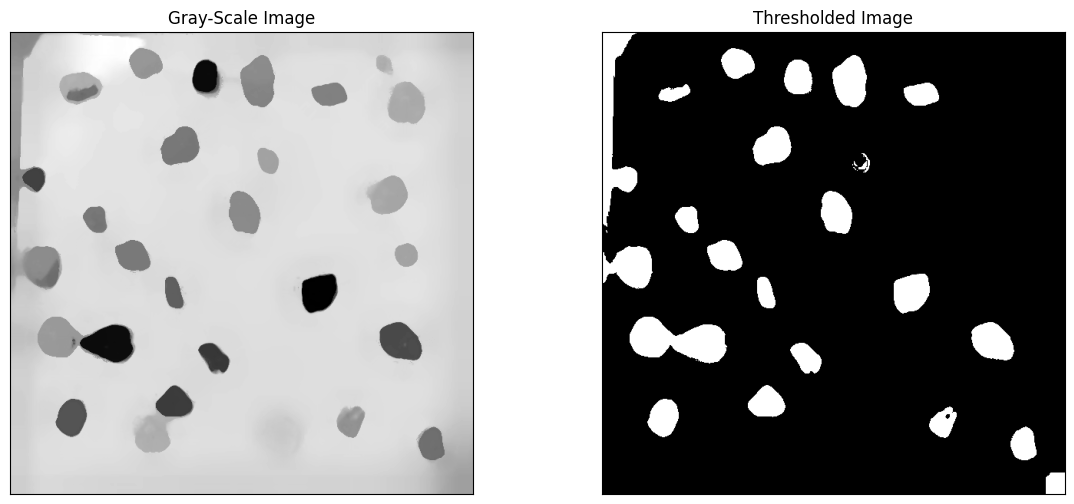

In [172]:
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
__, th = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.figure(figsize=(14, 6))
plt.subplot(121),plt.imshow(gray,cmap = 'gray')
plt.title('Gray-Scale Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(th,cmap = 'gray')
plt.title('Thresholded Image'), plt.xticks([]), plt.yticks([])
plt.show()

### Marker-Supported Watershed Algorithm

Although a pure contour-based approaches are simple and effective in many scenarios, it cannot separate particles that are adjacent, or right next to each other. 

Therefore, we employ watershed algorithm, which can **help us separate the boundaries of adjacent particles, or partially occluded particles**.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


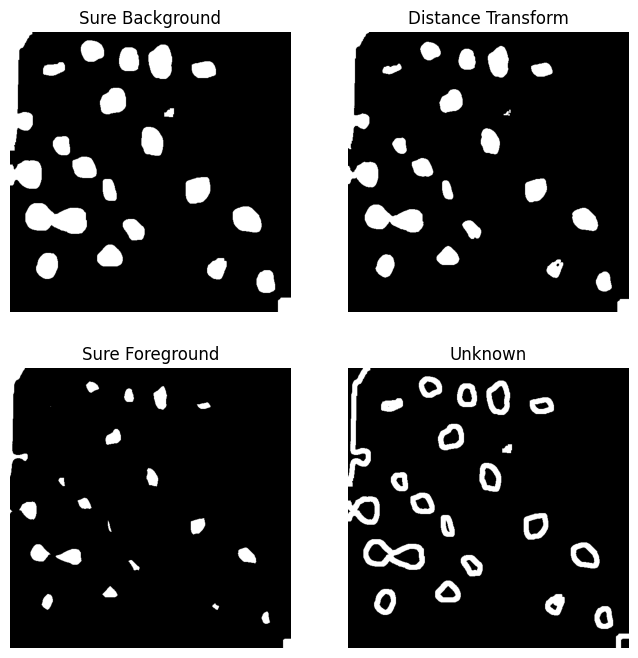

In [173]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
th = cv2.morphologyEx(th, 
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=1)

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# Sure Background
sure_bg = cv2.dilate(th, kernel, iterations=3)
imshow(sure_bg, axes[0,0])
axes[0, 0].set_title('Sure Background')
  
# Distance transform
dist = cv2.distanceTransform(th, cv2.DIST_L2, 5)
imshow(dist, axes[0,1])
axes[0, 1].set_title('Distance Transform')
  
# Sure Foreground area
ret, sure_fg = cv2.threshold(dist, FOREGROUND_THRESH * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = cv2.erode(sure_fg, kernel, iterations=1)
sure_fg = sure_fg.astype(np.uint8)  
imshow(sure_fg, axes[1,0])
axes[1, 0].set_title('Sure Foreground')
  
# Unknown Area
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1,1])
axes[1, 1].set_title('Unknown')
  
plt.show()

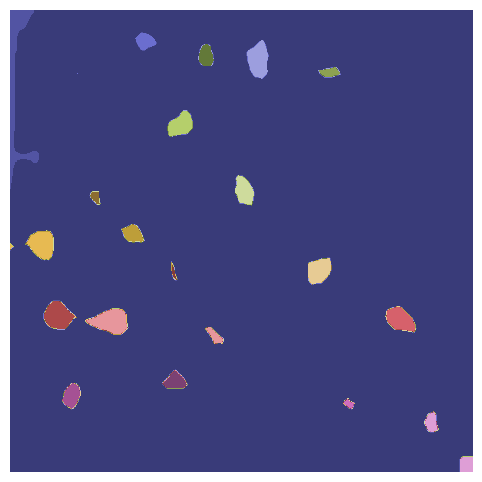

In [174]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers += 1
markers[unknown == 255] = 0
  
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

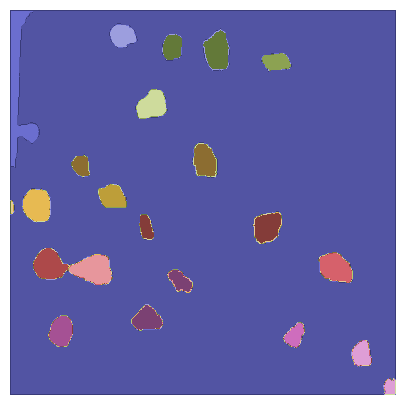

/tmp/ipykernel_23981/2221196175.py:22: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
/tmp/ipykernel_23981/2221196175.py:30: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = bigger_dim/smaller_dim


In [175]:
markers = cv2.watershed(image, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

labels = np.unique(markers)
mask = np.zeros_like(image)
coins = []
particle_sizes = []
for label in labels[2:]:
	target = np.where(markers == label, 255, 0).astype(np.uint8)
	
	# Perform contour extraction
	contours, hierarchy = cv2.findContours(
		target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
	)
		
	rect = cv2.minAreaRect(contours[0])
	box = cv2.boxPoints(rect)
	box = np.int0(box)

	# Calculate the width and height of the rectangle
	width = np.linalg.norm(box[0] - box[1])
	height = np.linalg.norm(box[1] - box[2])
	smaller_dim = min(width, height)
	bigger_dim = max(width, height)

	aspect_ratio = bigger_dim/smaller_dim

	if smaller_dim == 0:
		continue

	if aspect_ratio > MAX_AR:
		continue

	particle_sizes.append(smaller_dim)
	cv2.drawContours(mask, [box], 0, (0, 255, 0), 2)

	coins.append(contours[0])

In [176]:
particle_sizes = remove_outliers(particle_sizes)
len(particle_sizes)

19

In [177]:
def plotFour(img, th, mask, psd):
    # Draw the outline
    plt.figure(figsize=(14, 6))
    plt.subplot(141),plt.imshow(img, cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(142),plt.imshow(th,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(143),plt.imshow(mask,cmap = 'gray')
    plt.title('Min Rect Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(144)
    plt.show()

/tmp/ipykernel_23981/3200167269.py:41: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
/tmp/ipykernel_23981/755920274.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


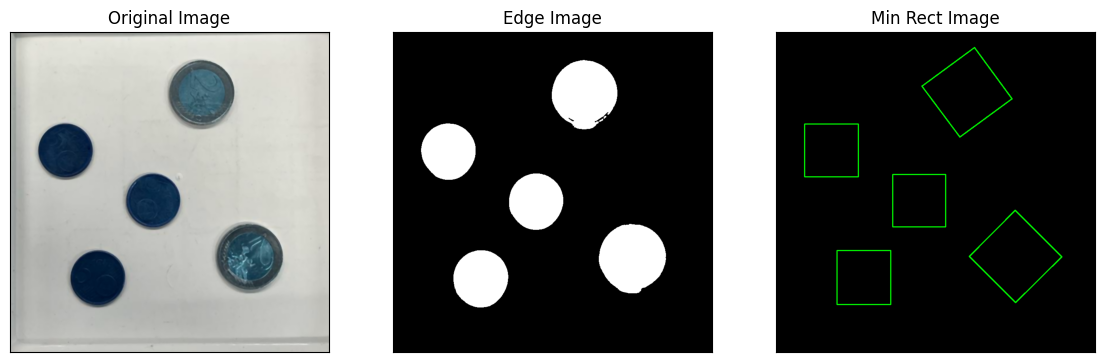

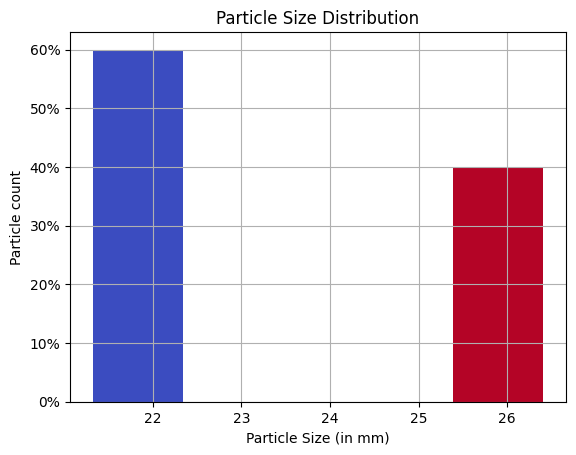

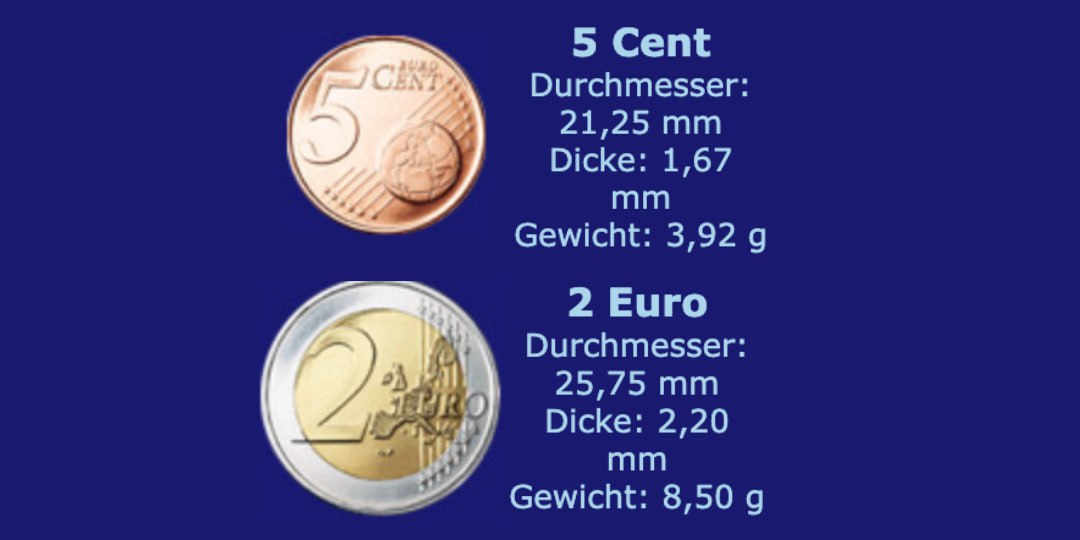

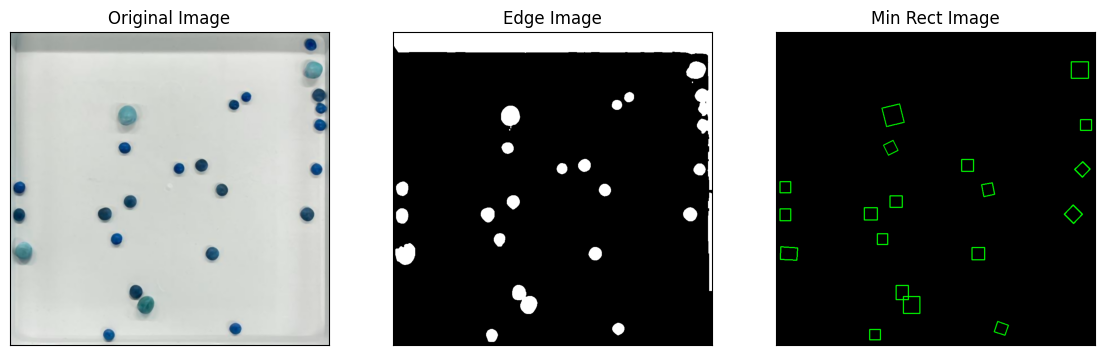

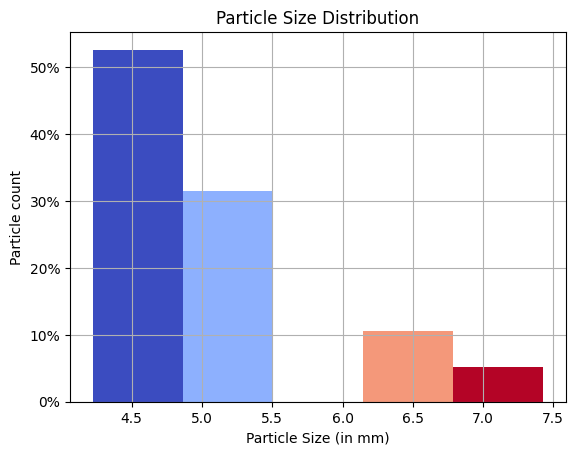

/tmp/ipykernel_23981/3200167269.py:49: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = bigger_dim/smaller_dim


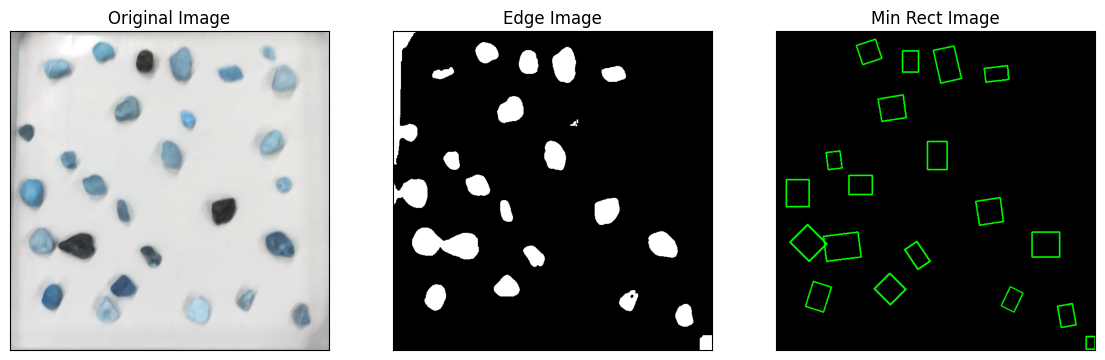

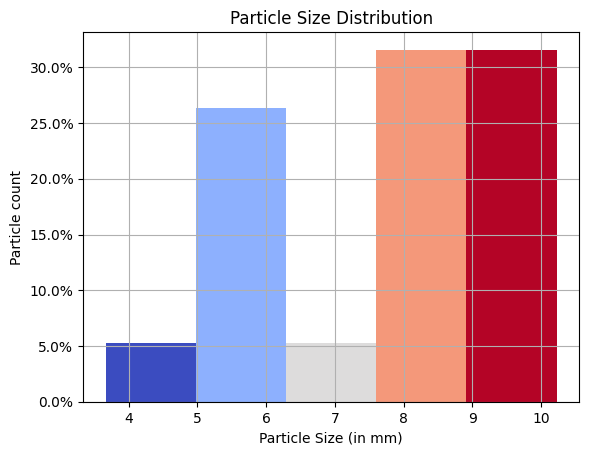

In [178]:
height, width = image.shape[0], image.shape[1]

img, th, mask, hist_list = watershed_segmentation('./sample0.png')
plt.figure(figsize=(14, 6))
plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(th, cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(mask, cmap = 'gray')
plt.title('Min Rect Image'), plt.xticks([]), plt.yticks([])
plt.figure(hist_list[0])
plt.show()

display(Image('./coins.jpg'))

img, th, mask, hist_list = watershed_segmentation('./sample3.png')
plt.figure(figsize=(14, 6))
plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(th, cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(mask, cmap = 'gray')
plt.title('Min Rect Image'), plt.xticks([]), plt.yticks([])
plt.figure(hist_list[0])
plt.show()

img, th, mask, hist_list = watershed_segmentation('./sample_val.png')
plt.figure(figsize=(14, 6))
plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(th, cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(mask, cmap = 'gray')
plt.title('Min Rect Image'), plt.xticks([]), plt.yticks([])
plt.figure(hist_list[0])
plt.show()